In [1]:
import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
import torch.nn.functional as F# type: ignore
from torch.utils.data import DataLoader # type: ignore
import torchvision.datasets as datasets# type: ignore
import torchvision.transforms as transforms# type: ignore


In [2]:
batch_size = 64
num_epochs = 10
learning_rate = 0.001
input_size = 32*32

In [3]:
train_dataset = datasets.CIFAR10(root='./dataset' ,train = True ,transform=transforms.ToTensor(),download=True)
train_loader = DataLoader(dataset=train_dataset , batch_size=batch_size ,shuffle=True)
test_dataset = datasets.CIFAR10(root='./dataset',train=False ,transform=transforms.ToTensor(),download=True)
test_loader = DataLoader(dataset=test_dataset , batch_size=batch_size ,shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [4]:

train_dataset[0][0].shape

torch.Size([3, 32, 32])

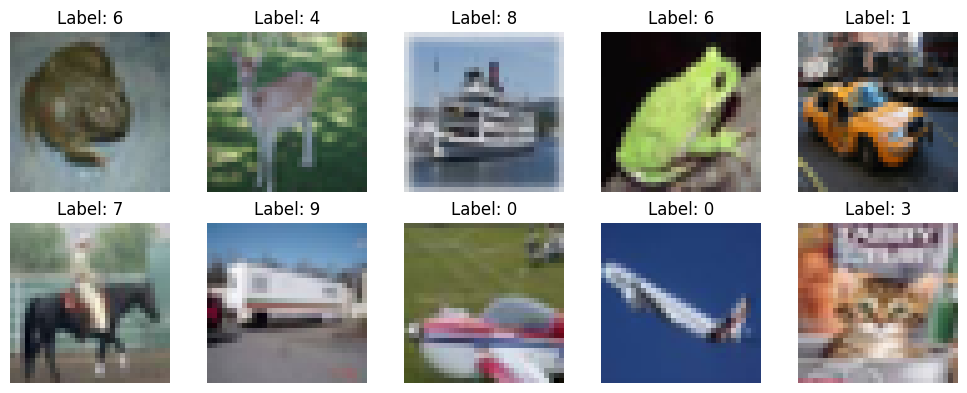

In [57]:
def show_image(image, label):
    plt.imshow(image.permute(1, 2, 0).numpy())  # Rearrange for plotting
    plt.title(f'Label: {label}')
    plt.axis('off')

# Function to display multiple images
def show_multiple_images(dataset, indices, ncols=5):
    n_images = len(indices)
    n_rows = (n_images + ncols - 1) // ncols  # Calculate the number of rows

    fig, axes = plt.subplots(n_rows, ncols, figsize=(ncols * 2, n_rows * 2))  # Create subplots
    axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

    for ax, idx in zip(axes, indices):
        image, label = dataset[idx]  # Get image and label
        ax.imshow(image.permute(1, 2, 0).numpy())  # Display image
        ax.set_title(f'Label: {label}')  # Display class name
        ax.axis('off')  # Hide axes

    # Hide any remaining empty subplots
    for ax in axes[n_images:]:
        ax.axis('off')

    plt.tight_layout()  # Adjust layout
    plt.show()

# Example usage: Show 10 random CIFAR-10 images
import random
indices = random.sample(range(len(train_dataset)), 10)  # Randomly select 10 indices
show_multiple_images(train_dataset, indices)


In [69]:
class CNN(nn.Module):
    def __init__(self ,in_channels = 3,num_classes=10):
        super(CNN,self).__init__()
                                #in : 32*32*3   out:32*32*32
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1)
                                #in : 32*32*32  out:16*16*32
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
                                #in : 16*16*32  out:16*16*64
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
                                #in : 16*16*64  out:8*8*64
        self.fc1 = nn.Linear(8*8*64,num_classes)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fc1(x)

        return x

In [70]:
model = CNN()
x = torch.randn(64,3,32,32)
model(x).shape

torch.Size([64, 10])

In [72]:
device = torch.device('cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = learning_rate)

In [74]:
def check_accuracy(loader,model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x,y in loader:
            x = x.to(device = device)
            y = y.to(device = device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    model.train()
    return num_correct / num_samples

#check_accuracy(train_loader,model)

In [ ]:
for epoch in range(num_epochs):
    print(f"epoch number :{epoch}      accuracy:{check_accuracy(train_loader,model)}")
    for batch_idx ,(data , targets) in enumerate(train_loader):
        data = data.to(device = device)
        targets = targets.to(device = device)

        scores = model(data)
        loss = criterion(scores,targets)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()